## Step 1. Login to datasites as **External Researcher**

Launch Datasites if not running:
```bash
$ python launch_datasites.py
```

In [1]:
import syft as sy

In [2]:
from datasites import CONNECTION_STRINGS

datasites = {}
for name, url in CONNECTION_STRINGS.items():
    datasites[name] = sy.login_as_guest(url=url)

Logged into <Cleveland Clinic: High-side Datasite> as GUEST
Logged into <Hungarian Inst. of Cardiology: High-side Datasite> as GUEST
Logged into <Univ. Hospitals Zurich and Basel: High-side Datasite> as GUEST
Logged into <V.A. Medical Center: High-side Datasite> as GUEST


## Step 2. Get Mock data and test the model evaluation code

In [3]:
mock_data = datasites["Cleveland Clinic"].datasets["Heart Disease Dataset"].assets["Heart Study Data"].mock

In [4]:
# DS/ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as mcc_score
from sklearn.metrics import confusion_matrix

from utils import load_model


# ML Data preparation - same strategy as in 02-Model-Training-Experiment.ipynb
def by_demographics(data):
    sex = data["sex"].map(lambda v: '0' if v == 0 else '1')
    target = data["num"].map(lambda v: '0' if v == 0 else '1')
    return (sex+target).values

# 1. get features and labels
X = mock_data.drop(columns=["age", "sex", "num"], axis=1)
y = mock_data["num"].map(lambda v: 0 if v == 0 else 1)
# 2. partition data
_, X_test, _, y_test = train_test_split(
    X, y, random_state=12345, stratify=by_demographics(mock_data)
)
# 3. Load Trained model
model_dump_file = "./models/cleveland_clinic_model.jbl"
classifier = load_model(model_dump_file)
# 4. Evaluate Metrics (MCC and Confusion Matrix)
y_pred = classifier.predict(X_test)
mcc_test = mcc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
# expect nearly zero as it's random data! If it's not, there's a problem :D
print(mcc_test)  
print(cm)

-0.06419407387663695
[[ 2  9]
 [11 33]]


## Step 3. Submit Experiment to each datasite

In [5]:
# get model files
from utils import load_models

models = load_models(datasites)
assert len(models) == 4

In [6]:
from utils import serialize_and_upload
remote_models = {}

for name, datasite in datasites.items():
    print(f"Datasite: {name}")
    # 1. Get data asset from datasite
    data_asset = datasite.datasets["Heart Disease Dataset"].assets["Heart Study Data"]
    # 1.1 Upload models to Datasite (to be mapped as input to the Syft function)
    remote_model = serialize_and_upload(model=models[name], to=datasite)
    remote_models[name] = remote_model
    
    @sy.syft_function_single_use(data=data_asset, model=remote_model)
    def evaluate(data, model):
        # DS/ML libraries
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import matthews_corrcoef as mcc_score
        from sklearn.metrics import confusion_matrix
        import joblib
        
        # ML Data preparation - same strategy as in model training
        def by_demographics(data):
            sex = data["sex"].map(lambda v: '0' if v == 0 else '1')
            target = data["num"].map(lambda v: '0' if v == 0 else '1')
            return (sex+target).values
        
        # 1. get features and labels
        X = data.drop(columns=["age", "sex", "num"], axis=1)
        y = data["num"].map(lambda v: 0 if v == 0 else 1)
        # 2. partition data
        _, X_test, _, y_test = train_test_split(
            X, y, random_state=12345, stratify=by_demographics(data)
        )
        # 3. Get trained model
        classifier = joblib.load(model)  # serialised model
        # 4. Evaluate Metrics (MCC and Confusion Matrix)
        y_pred = classifier.predict(X_test)
        return mcc_score(y_test, y_pred), confusion_matrix(y_test, y_pred)
    
    ml_eval_project = sy.Project(
        name="Evaluate Trained RandomForest Classifier on Heart Study Data",
        description="""I would like to evaluate prediction of the trained RandomForest Classifier.""",
        members=[datasite],
    )
    ml_eval_project.create_code_request(evaluate, datasite)
    project = ml_eval_project.send()

Datasite: Cleveland Clinic


SyftSuccess: Syft function 'evaluate' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Datasite: Hungarian Inst. of Cardiology


SyftSuccess: Syft function 'evaluate' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Datasite: Univ. Hospitals Zurich and Basel


SyftSuccess: Syft function 'evaluate' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Datasite: V.A. Medical Center


SyftSuccess: Syft function 'evaluate' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

In [7]:
from utils import check_status_last_code_requests

check_status_last_code_requests(datasites)

Datasite: Cleveland Clinic


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

Datasite: Hungarian Inst. of Cardiology


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

Datasite: Univ. Hospitals Zurich and Basel


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

Datasite: V.A. Medical Center


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

## Step 4. Evaluate Models on all datasites

In [8]:
mcc_scores, confusion_matrices = {}, {}
for name, datasite in datasites.items():
    print(f"Datasite: {name}")
    data_asset = datasite.datasets["Heart Disease Dataset"].assets["Heart Study Data"]
    remote_model = remote_models[name]
    results = datasite.code.evaluate(data=data_asset, model=remote_model).get_from(datasite)
    mcc_scores[name], confusion_matrices[name] = results

Datasite: Cleveland Clinic
Datasite: Hungarian Inst. of Cardiology
Datasite: Univ. Hospitals Zurich and Basel
Datasite: V.A. Medical Center


In [9]:
mcc_scores

{'Cleveland Clinic': 0.7660432093927659,
 'Hungarian Inst. of Cardiology': 0.46145417301564956,
 'Univ. Hospitals Zurich and Basel': 0.0,
 'V.A. Medical Center': 0.25837775979961347}

Data is so skew (as expected) in the 'Univ. Hospitals Zurich and Basel' that the model is practically predicting random, like "coin toss" (i.e. `MCC = 0`).

Let's double check the resulting Confusion Matrices, and then will see if we can do better!

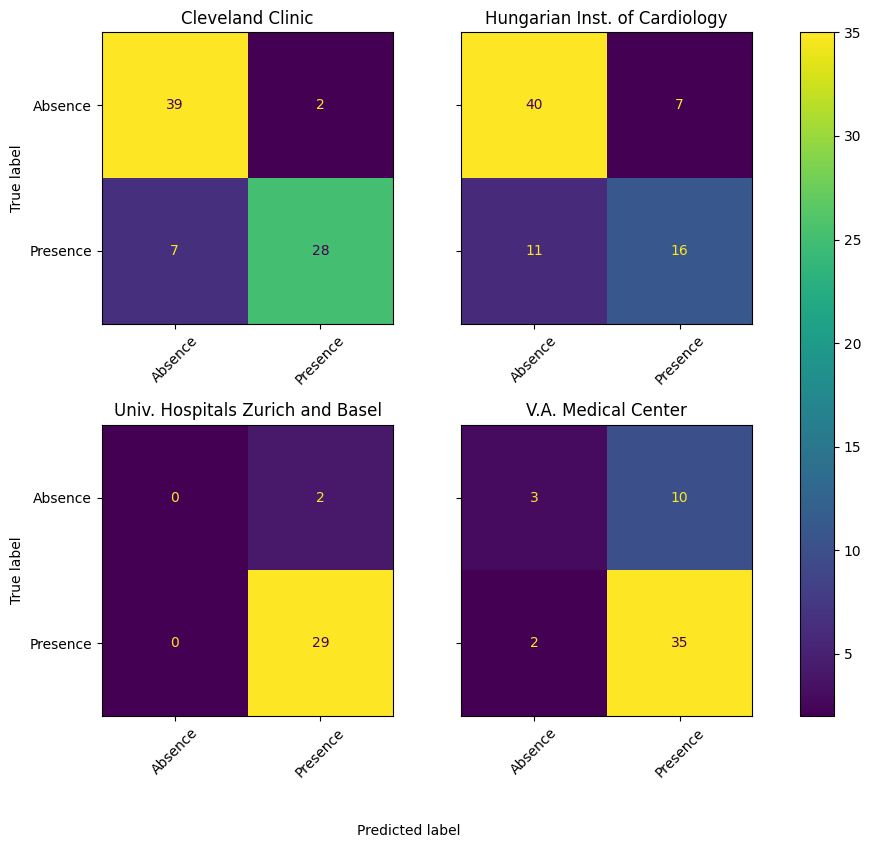

In [10]:
from matplotlib import pyplot as plt
from utils import plot_all_confusion_matrices

plot_all_confusion_matrices(confusion_matrices)
plt.show()

### Conclusions 🙌

We have gathered evaluation metrics for each machine learning model using data of each corresponding datasite - and we were able to do so by never looking at the true (non-public) data of each Hospital!

#### Excercise

As an exercise, you could try to check how models perform on _test data_ gathered from datasites different than the one used in training!

Considering the code of our experiment, the only thing you'd need to change is which model you would pass in as input to our `evaluate` function! 😉